# Modules

In [51]:
%load_ext google.colab.data_table

#Packages
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

#Tools
from sklearn import svm
from statistics import mean
from google.colab import drive
from google.colab import data_table
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [52]:
#Avoid warnings
import warnings
warnings.filterwarnings('ignore')

#mount Drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"

#Configuration
pd.set_option('display.max_columns', None)
sns.set_palette("husl", 9)
class_names_complete = ['Sanos', 'Talasemias', 'Hemoglobinopatías', 'A.Ferropénicas', 'A.Crónico']
class_names_reduced = ['Sanos', 'Congénitas', 'Adquiridas']

Mounted at /content/drive


# Data loading

In [53]:
#Load CSV fie
CBC_file_dir = root_dir + "Data/ProcessedData-2021-Filtrados.csv"
CBC = pd.read_csv(CBC_file_dir, error_bad_lines=True)
CBC["Clase"] = CBC["Clase"].astype(int)
print('File loaded, shape:(%s, %s)' %((len(CBC), len(CBC.iloc[0]))))

File loaded, shape:(3295, 18)


In [54]:
#Check random sample
data_table.DataTable(CBC.head(100), include_index=False, num_rows_per_page=10)

,Edad,WBC,LYAB,MOAB,NEAB,EO,BA,HEMA,HGB,HTO,VCM,MCH,CHCM,RDW,PLT,VPM,Clase,TipoClase
0,0.117647,0.145740,0.075908,0.250000,0.118182,0.351429,0.122807,0.376455,0.605882,0.530957,0.451574,0.455738,0.715385,0.068493,0.089410,0.557692,0,-1.0
1,0.519608,0.087444,0.049505,0.107143,0.090909,0.034286,0.087719,0.331177,0.582353,0.491557,0.483051,0.504918,0.769231,0.037671,0.099826,0.259615,0,-1.0
2,0.441176,0.132287,0.029703,0.214286,0.186364,0.065714,0.245614,0.469599,0.647059,0.579737,0.366828,0.367213,0.676923,0.157534,0.231771,0.250000,0,-1.0
3,0.754902,0.177130,0.016502,0.142857,0.318182,0.005714,0.000000,0.291074,0.458824,0.382739,0.395884,0.413115,0.723077,0.157534,0.211806,0.307692,0,-1.0
4,0.666667,0.161435,0.066007,0.214286,0.195455,0.108571,0.122807,0.397154,0.694118,0.604128,0.515738,0.527869,0.746154,0.130137,0.150174,0.346154,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.784314,0.304933,0.110398,0.217705,0.184689,0.028571,0.350877,0.278137,0.629412,0.568480,0.727603,0.681967,0.661538,0.335616,0.163194,0.365385,0,-1.0
96,0.480392,0.109865,0.033003,0.285714,0.118182,0.174286,0.403509,0.363519,0.652941,0.527205,0.470944,0.537705,0.869231,0.109589,0.198785,0.413462,0,-1.0
97,0.833333,0.426009,0.264026,0.285714,0.459091,0.008571,0.035088,0.510996,0.682353,0.632270,0.369249,0.350820,0.623077,0.106164,0.196181,0.365385,0,-1.0
98,0.656863,0.154709,0.056106,0.178571,0.204545,0.082857,0.087719,0.454075,0.741176,0.643527,0.467312,0.488525,0.761538,0.089041,0.179688,0.461538,0,-1.0


# Data Selection

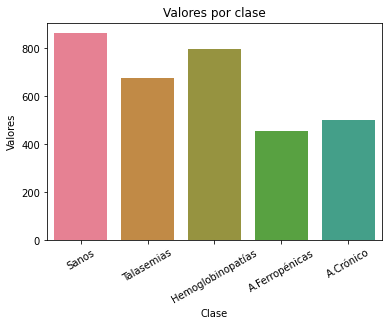

In [55]:
chart = sns.countplot(x='Clase', data=CBC)
plt.ylabel("Valores")
plt.title('Valores por clase')
chart.set_xticklabels(class_names_complete, rotation=30, fontsize=10);

In [56]:
#Select classes we are going to work with
#In this case, we merge in 3 subgroups: Sanos, Congenitas and Adquiridas

#CBC = CBC[CBC['Clase'] != 2] 
CBC['Clase'] = CBC['Clase'].replace(to_replace = 2, value = 1)
CBC['Clase'] = CBC['Clase'].replace(to_replace = 3, value = 2) 
CBC['Clase'] = CBC['Clase'].replace(to_replace = 4, value = 2) 

In [57]:
healthy = CBC.loc[CBC['Clase'] == 0]
thalassemias = CBC.loc[CBC['Clase'] == 1]
anemias = CBC.loc[CBC['Clase'] == 2]

#Pick only specific thalassemias
#thalassemias = thalassemias.loc[(thalassemias['TipoClase'] == 7) | (thalassemias['TipoClase'] == 4) | (thalassemias['TipoClase'] == 3)]

CBC = pd.concat([healthy,thalassemias, anemias])
print(CBC['Clase'].value_counts(sort=False))

0     863
2     959
1    1473
Name: Clase, dtype: int64


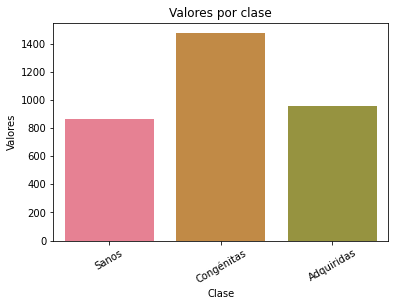

In [58]:
chart = sns.countplot(x='Clase', data=CBC)
plt.ylabel("Valores")
plt.title('Valores por clase')
chart.set_xticklabels(class_names_reduced, rotation=30, fontsize=10);

In [59]:
CBC = CBC.sample(frac = 1)

labels = CBC['Clase']
CBC = CBC.drop('Clase', axis=1)
CBC = CBC.drop('TipoClase', axis=1)
CBC.replace(0,CBC.mean(axis=0),inplace=True)

In [60]:
print(CBC.columns)

Index(['Edad', 'WBC', 'LYAB', 'MOAB', 'NEAB', 'EO', 'BA', 'HEMA', 'HGB', 'HTO',
       'VCM', 'MCH', 'CHCM', 'RDW', 'PLT', 'VPM'],
      dtype='object')


In [61]:
CBC = CBC.to_numpy()

# Model Selection

In [62]:
def calculateBestParamsRF(data, original_labelsl):

  X_train, X_test, y_train, y_test = train_test_split(CBC, labels, test_size = 0.2)
  param_grid = {'n_estimators': [10, 100, 500, 1000], 'min_samples_leaf': [1,2,4], 'min_samples_split':[2,5,10], 'class_weight':['balanced']} 
  grid = GridSearchCV(RandomForestClassifier(oob_score=True), param_grid, refit = True, verbose = 1, cv=2)
  grid.fit(X_train, y_train)
  print(grid.best_params_)

  return (grid.best_params_)

In [63]:
best_params = calculateBestParamsRF(CBC,labels)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  2.2min finished


{'class_weight': 'balanced', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}


# Results

In [64]:
def calculateRF(data, original_labels, best_params):
  model = RandomForestClassifier(oob_score=True, n_estimators=best_params['n_estimators'], min_samples_leaf=best_params['min_samples_leaf'], min_samples_split=best_params['min_samples_split'], class_weight='balanced')
  scores = cross_val_score(model, CBC, labels, cv=10)
  print('Best score: ', mean(scores))

  x_train, x_test, y_train, y_test = train_test_split(CBC, labels, test_size=0.20)
  rfm = model.fit(x_train,y_train)
  y_pred = rfm.predict(x_test)

  con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm, index = class_names_reduced, columns = class_names_reduced)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('Etiqueta real')
  plt.xlabel('Etiqueta predicha')
  plt.show()


Best score:  0.7344524270056185


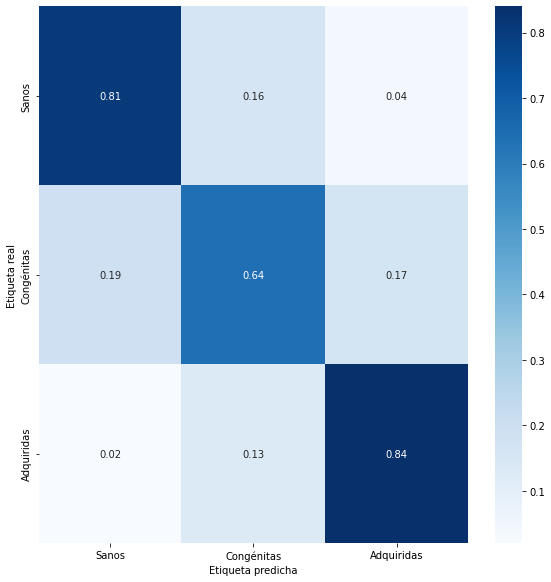

In [65]:
calculateRF(CBC,labels,best_params)